In [5]:
pip install catboost

In [231]:
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report,make_scorer,precision_score,recall_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier


In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/joshuasir/datasets/main/stock-market-train-clean.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/joshuasir/datasets/main/stock-market-test-clean.csv')

In [8]:
X = df.copy()
# X = df.drop(columns=['SMA'],axis=1).copy()
y = X.pop('Target')
X_valid = df_test.copy()
y_valid = X_valid.pop('Target')

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)

In [9]:
y.value_counts()

0    68651
1    14020
Name: Target, dtype: int64

we will be using cross validation and precision as our metric since our data is unbalance

## Baseline Model

In [ ]:
model = DummyClassifier(strategy='stratified')


scoring = {'Accuracy': 'accuracy',
           'Precision': 'precision_macro',
           'Recall': 'recall_macro',
           'F1':'f1_macro',
    }


scores = cross_validate(model, X_train, y_train,
                              cv=5,
                              scoring=scoring)

print("Precision scores:\n", scores['test_Precision'].mean())
print("Recall scores:\n", scores['test_Recall'].mean())
print("F1 scores:\n", scores['test_F1'].mean())

# print('Dummy Classifier :', model.score(y_test,pred))
# print(classification_report(y_test,pred))

Precision scores:
 0.5009514895321907
Recall scores:
 0.5009651825741926
F1 scores:
 0.5009450303376368


## Comparing Model

In [82]:

def train(classifier,name='',graph=False):
    
    scoring = {'Accuracy': 'accuracy',
           'Precision': 'precision_macro',
           'Recall': 'recall_macro',
           'F1':'f1_macro',
           'ROC_AUC'  : 'roc_auc'
    }
    score_dict = cross_validate(classifier, X_train, y_train,
                              cv=10,
                              scoring=scoring)
    
    scores = pd.DataFrame(columns=['Model','Precision','Recall','F1','ROC AUC'])
    scores = scores.append(pd.Series({ 
                                      'Model' : name,
                                      # 'Accuracy' : score_dict['test_Accuracy'].mean(),
                                      'Precision' : score_dict['test_Precision'].mean(),
                                      'Recall' : score_dict['test_Recall'].mean(),
                                      'F1' : score_dict['test_F1'].mean(),
                                      'ROC AUC' : score_dict['test_ROC_AUC'].mean()
    }),ignore_index=True)
 
    return scores

In [83]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer


models =  { "Decision Tree" : DecisionTreeClassifier(),
            "Random Forest" : RandomForestClassifier(),
            "XGBoost" : XGBClassifier(), 
            "LogisticRegression" : LogisticRegression(max_iter=1200), 
            "CatBoost" :CatBoostClassifier(verbose=False) ,
            'LGBM' : LGBMClassifier(),
            'KNeighbors' : KNeighborsClassifier(),
            'AdaBoost' : AdaBoostClassifier()
            }

scores = pd.DataFrame(columns=['Model','Precision','Recall','F1','ROC AUC'])
# probability = {}

for model in models:
  scores = scores.append(train(models[model],name=model))

In [84]:
scores.sort_values('Precision',ascending=False).reset_index(drop=True)

,Model,Precision,Recall,F1,ROC AUC
0,XGBoost,0.826872,0.745354,0.776239,0.937858
1,LGBM,0.818918,0.748048,0.775862,0.937156
2,CatBoost,0.811829,0.748561,0.774013,0.935933
3,AdaBoost,0.807188,0.751260,0.774149,0.933819
4,Random Forest,0.779375,0.737577,0.755370,0.928250
5,LogisticRegression,0.774314,0.786072,0.779738,0.927539
6,Decision Tree,0.745449,0.745677,0.745409,0.745677
7,KNeighbors,0.726452,0.687182,0.703143,0.805172


XGBoost shows great promise

In [86]:
cross_validate(XGBClassifier(), X_train, y_train, cv=10, scoring='precision_macro')['test_score'].mean()

0.8430288543594381

## Model Train

In [ ]:

param_grid = {
    'max_depth':[4,5,7],
    'min_child_weight':[3,4,6],
    'subsample':[1,.7]
}

grid = GridSearchCV(estimator=XGBClassifier(),param_grid = param_grid,cv=5)
grid.fit(X_train,y_train)


In [93]:
grid.best_params_

{'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.7}

In [214]:
model = XGBClassifier(max_depth= 4, min_child_weight= 3, subsample= 0.7)

model.fit(X_train,y_train)
pred = model.predict(X_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94     20596
           1       0.78      0.50      0.61      4206

    accuracy                           0.89     24802
   macro avg       0.84      0.74      0.77     24802
weighted avg       0.88      0.89      0.88     24802



We will try moving the threshold as we want to capture a more profitable precision score

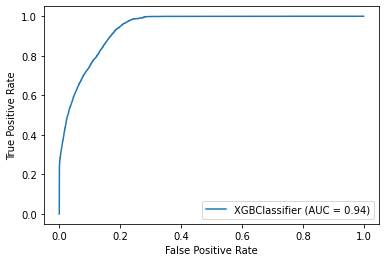

In [96]:
from sklearn import metrics
metrics.plot_roc_curve(model, X_test, y_test)

In [256]:
threshold = .5

In [257]:
score = model.predict_proba(X)[:, 1]
result = [(i > threshold) for i in score]
print(classification_report(y, result, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     68651
           1       0.79      0.50      0.61     14020

    accuracy                           0.89     82671
   macro avg       0.85      0.74      0.78     82671
weighted avg       0.89      0.89      0.88     82671



In [258]:
def evaluation(model,X,y,threshold=threshold):
  score = model.predict_proba(X)[:, 1]
  result = [(i > threshold) for i in score]
  # print(classification_report(y, result, labels=[0,1]))
  print('Precision avg :', precision_score(y,result,average='weighted'))
  print('Recall avg :', recall_score(y,result,average='weighted'))

In [259]:
evaluation(model,X_test,y_test)

Precision avg : 0.8845408781311309
Recall avg : 0.8919441980485445


## Evaluation

In [260]:
evaluation(model,X_valid,y_valid)

Precision avg : 0.823685463435567
Recall avg : 0.7658940890366768
